In [66]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
folder_path = 'data/'
file_names = os.listdir(folder_path)
print(file_names)
file_names = [file_name for file_name in file_names if file_name.endswith('.npy')]
file_names.sort()
file_paths = [os.path.join(folder_path, file_name) for file_name in file_names]
labels = []
for file_name in file_names:
    if file_name.endswith('-L.npy'):
        labels.append('LoRa')
    elif file_name.endswith('-N.npy'):
        labels.append('Non-LoRa')
for file_path, label in zip(file_paths, labels):
    print(f"File: {file_path}, Label: {label}")

['sliceN3_546-N.npy', 'slice_310-L.npy', 'sliceN2_813-N.npy', 'sliceN1_729-N.npy', 'slice4_650-L.npy', 'sliceN2_94-N.npy', 'slice4_281-L.npy', 'sliceA4_444-L.npy', 'sliceN3_197-N.npy', 'sliceN2_481-N.npy', 'sliceN_278-N.npy', 'slice_355-L.npy', 'sliceA4_893-L.npy', 'sliceN3_503-N.npy', 'sliceN2_856-N.npy', 'slice4_615-L.npy', 'sliceA4_401-L.npy', 'sliceN3_991-N.npy', 'slice_784-L.npy', 'slice3_399-L.npy', 'sliceN3_94-N.npy', 'sliceA_646-L.npy', 'sliceA2_809-L.npy', 'sliceA1_733-L.npy', 'sliceA_297-L.npy', 'slice1_527-L.npy', 'slice3_748-L.npy', 'sliceN4_889-N.npy', 'sliceA3_519-L.npy', 'sliceA1_776-L.npy', 'sliceA_603-L.npy', 'slice4_78-L.npy', 'slice1_562-L.npy', 'sliceN4_336-N.npy', 'slice3_863-L.npy', 'slice2_536-L.npy', 'sliceA2_722-L.npy', 'sliceA3_234-L.npy', 'sliceA1_818-L.npy', 'sliceN4_373-N.npy', 'slice3_826-L.npy', 'slice2_573-L.npy', 'sliceA_928-L.npy', 'sliceA2_767-L.npy', 'sliceA3_271-L.npy', 'sliceN1_490-N.npy', 'sliceN_510-N.npy', 'sliceN2_738-N.npy', 'sliceN1_802-N.npy

In [3]:
class CustomDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.file_paths)
    def __getitem__(self, idx):
        array = np.load(self.file_paths[idx])
        if self.transform:
            array = self.transform(array)
        tensor = torch.tensor(array, dtype=torch.float64) 
        label = self.labels[idx]
        return tensor, label

In [4]:
dataset = CustomDataset(file_paths, labels)

In [11]:
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [21]:
# for i, batch in enumerate(dataloader):
#     print(f"Batch {i+1}:")
#     print(batch)
#     print("Batch size:", len(batch[0]))
#     print()
#     break

In [13]:
class FFTTransform(object):
    def __init__(self, dim=-1):
        self.dim = dim
    def __call__(self, array):
        tensor = torch.tensor(array, dtype=torch.float64)
        fft_result = torch.fft.fft(tensor, dim=self.dim)
        return fft_result
transform = transforms.Compose([
    FFTTransform(dim=1), 
])

In [14]:
datasetT = CustomDataset(file_paths,labels, transform=transform)

In [15]:
dataloaderT = DataLoader(datasetT, batch_size=batch_size, shuffle=True)

In [20]:
# import matplotlib.pyplot as plt
# # Iterate over the dataloader to view the batches of data
# for i, batch in enumerate(dataloader):
#     print(f"Batch {i+1}:")
#     # Visualize each tensor in the batch
#     for j, tensor in enumerate(batch[0]):
#         plt.figure()
#         plt.plot(tensor.numpy())
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.title(f'Tensor {j+1} in Batch {i+1}')
#         plt.show()
#     break


In [19]:
# import matplotlib.pyplot as plt
# # Iterate over the dataloader to view the batches of data
# for i, batch in enumerate(dataloaderT):
#     print(f"Batch {i+1}:")
#     # Visualize each tensor in the batch
#     for j, tensor in enumerate(batch[0]):
#         plt.figure()
#         plt.plot(tensor.numpy())
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.title(f'Tensor {j+1} in Batch {i+1}')
#         plt.show()
#         break


In [22]:
import torch.nn as nn


In [60]:
class CNN2D(nn.Module):
    def __init__(self):
        super(CNN2D, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(1, 3)),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(1, 3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2))
        )
        for _ in range(4):  # Repeat the conv layers 5 times
            self.conv_layers.add_module('conv_block', nn.Sequential(
                nn.Conv2d(128, 128, kernel_size=(1, 3)),
                nn.ReLU(),
                nn.Conv2d(128, 128, kernel_size=(1, 3)),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(1, 2))
            ))
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 1, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = x.float()
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [61]:
model = CNN2D()


In [62]:
print(model)


CNN2D(
  (conv_layers): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (conv_block): Sequential(
      (0): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=2, bias=True)
    (7): Softmax(dim=1)
  )
)


In [63]:
import torch.optim as optim


In [64]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

/var/folders/2d/fcgrngd95_b823fdj1fwwj840000gn/T/ipykernel_15596/2043309677.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(array, dtype=torch.float64)


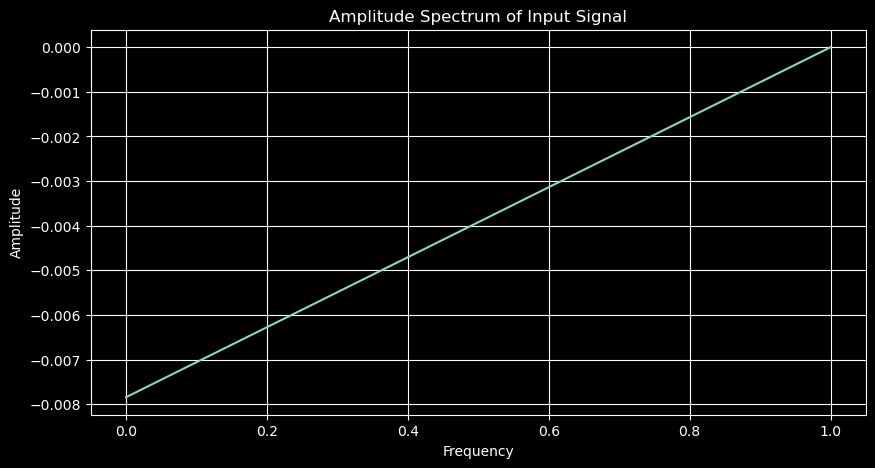

RuntimeError: Calculated padded input size per channel: (8192 x 2). Kernel size: (1 x 3). Kernel size can't be greater than actual input size

In [67]:
for epoch in range(num_epochs):
    model.train()    
    running_loss = 0.0
    correct = 0
    total = 0
    for data in dataloaderT:
        inputs, labels = data
        input_array = inputs[0].detach().numpy()
        plt.figure(figsize=(10, 5))
        plt.plot(input_array[0]) 
        plt.title('Amplitude Spectrum of Input Signal')
        plt.xlabel('Frequency')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.show()  
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloaderT):.4f}, Accuracy: {(correct/total)*100:.2f}%")

/var/folders/2d/fcgrngd95_b823fdj1fwwj840000gn/T/ipykernel_15596/2043309677.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(array, dtype=torch.float64)


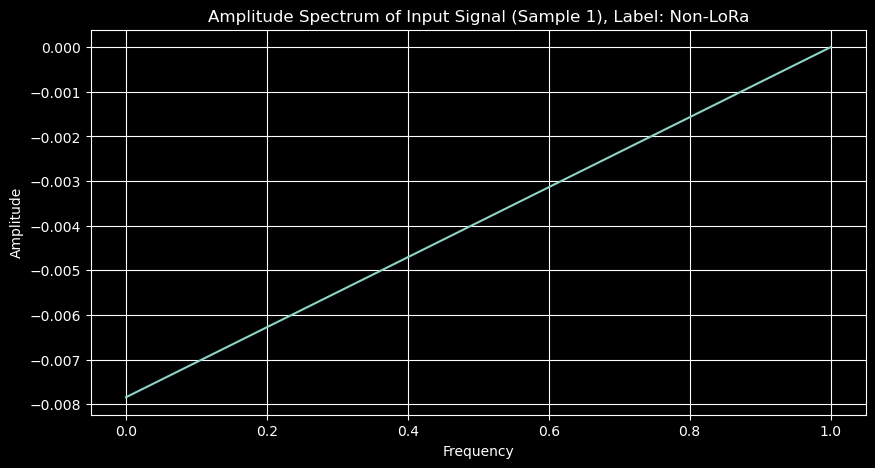

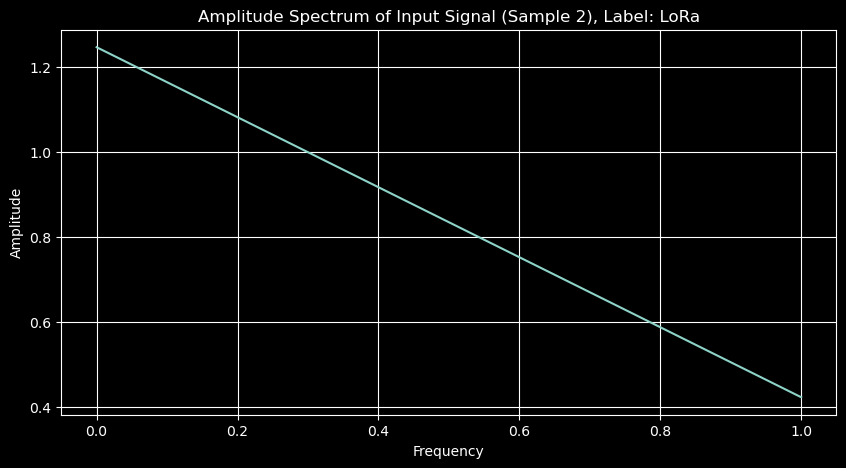

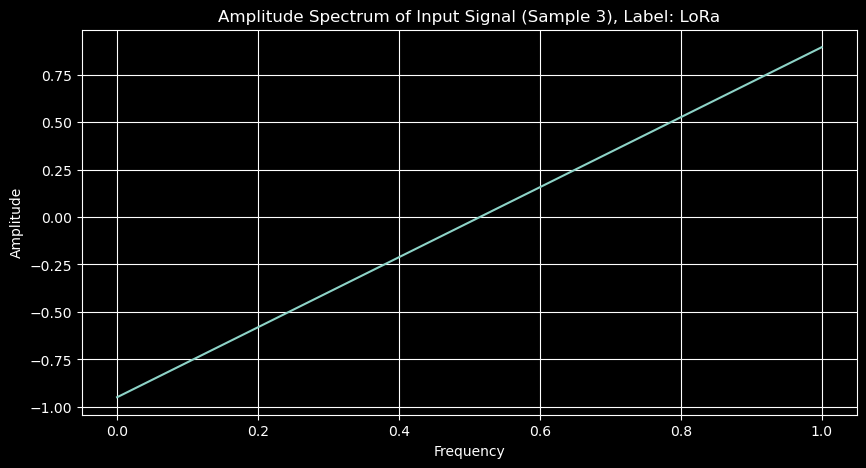

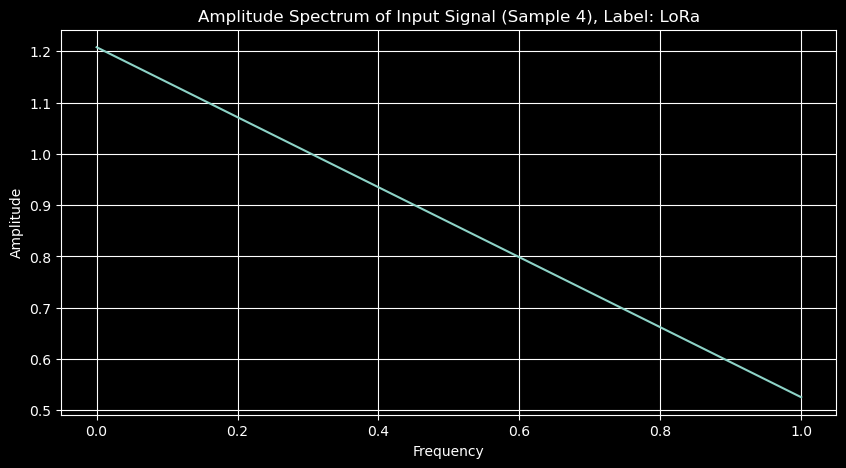

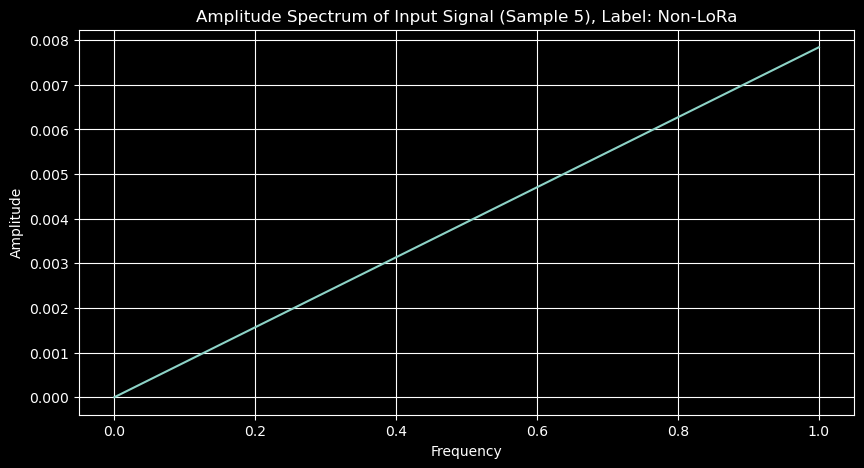

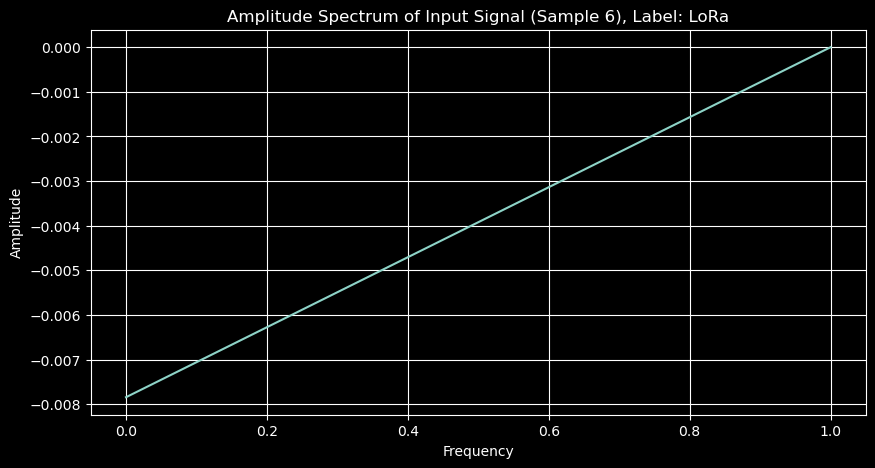

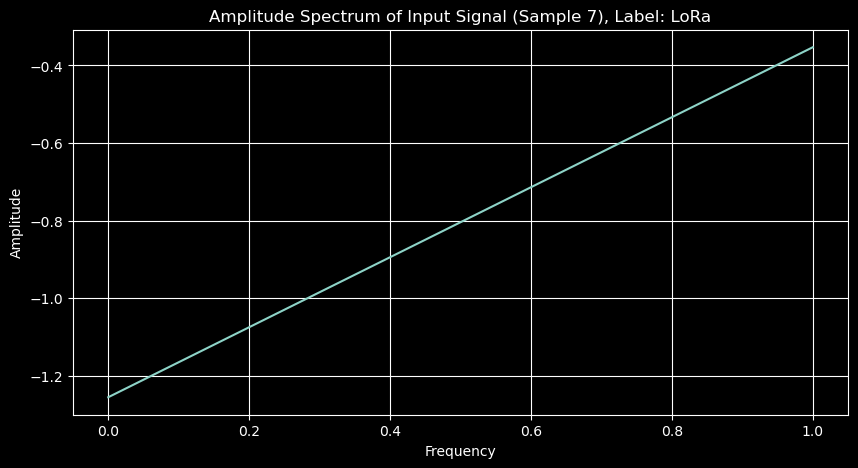

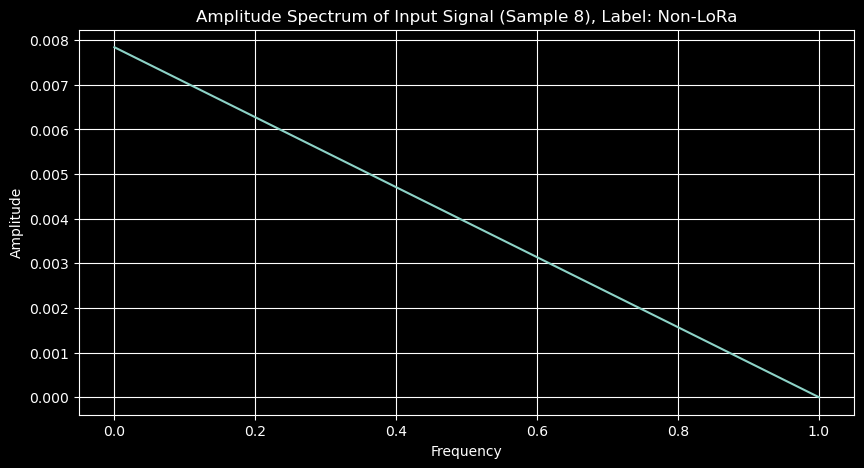

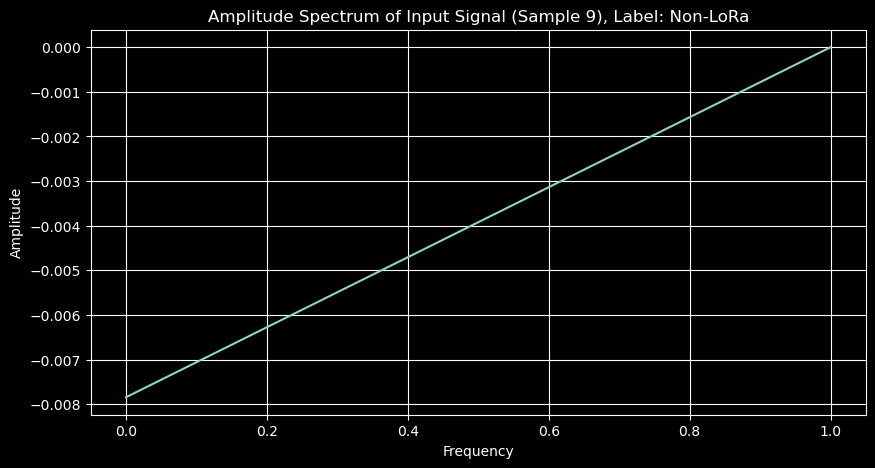

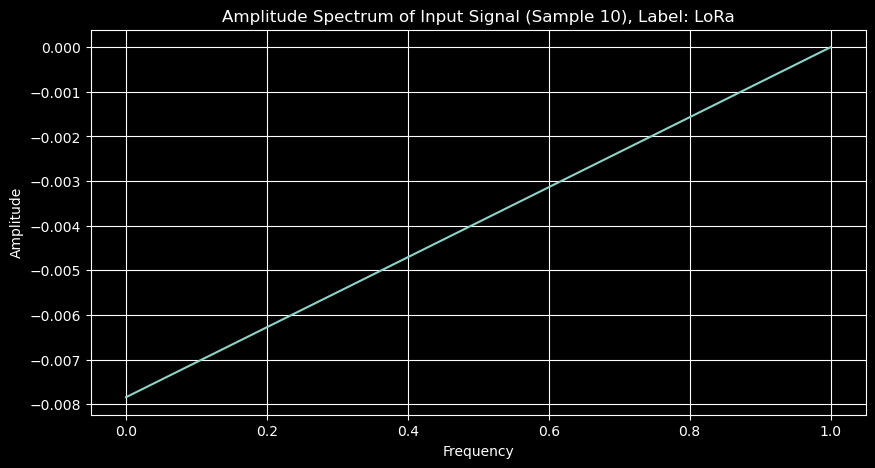

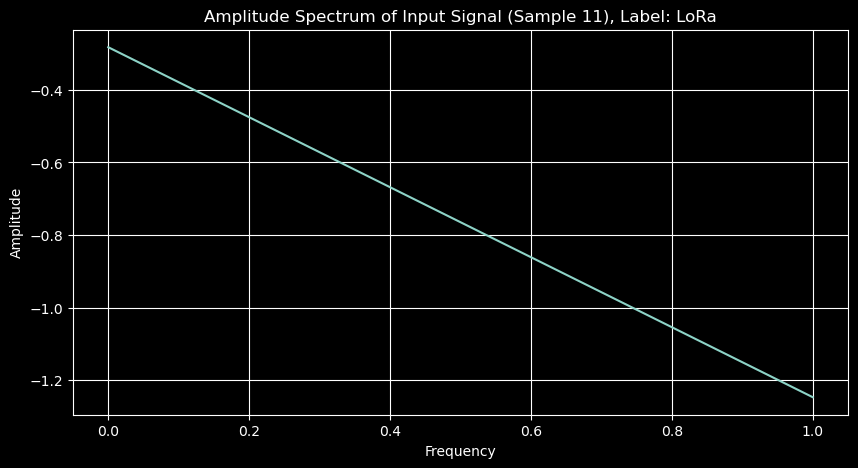

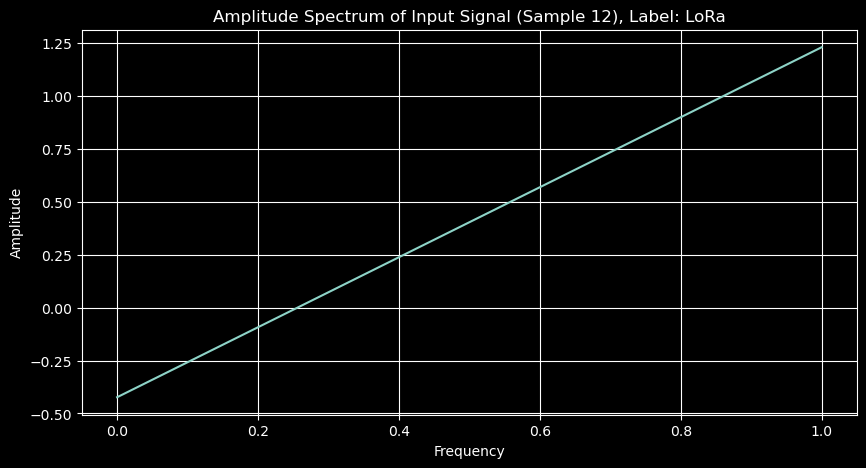

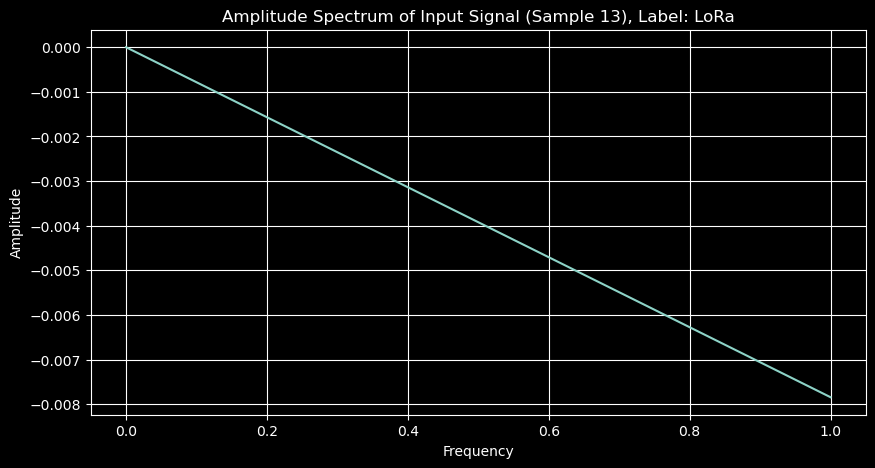

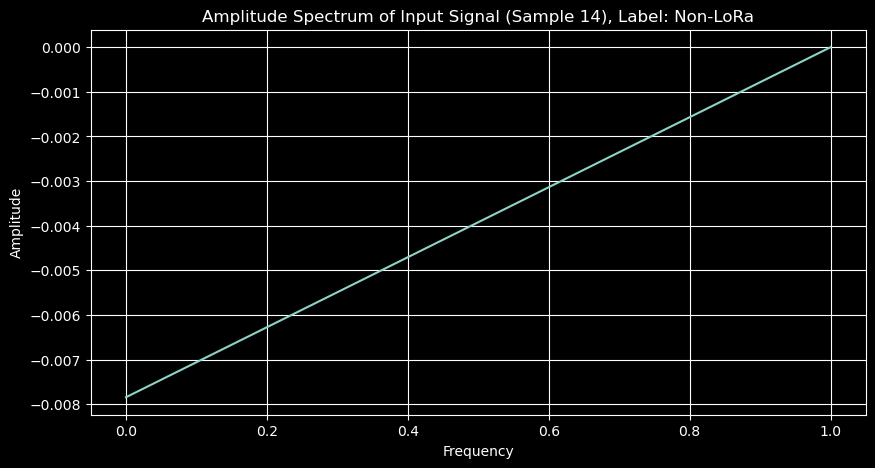

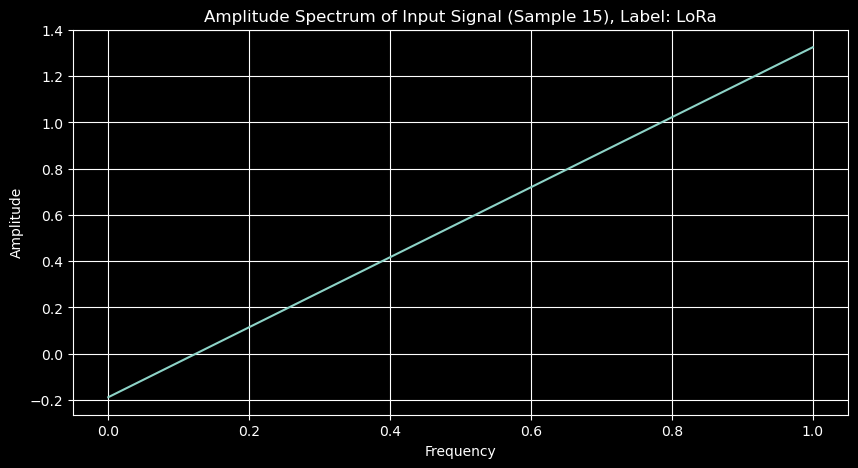

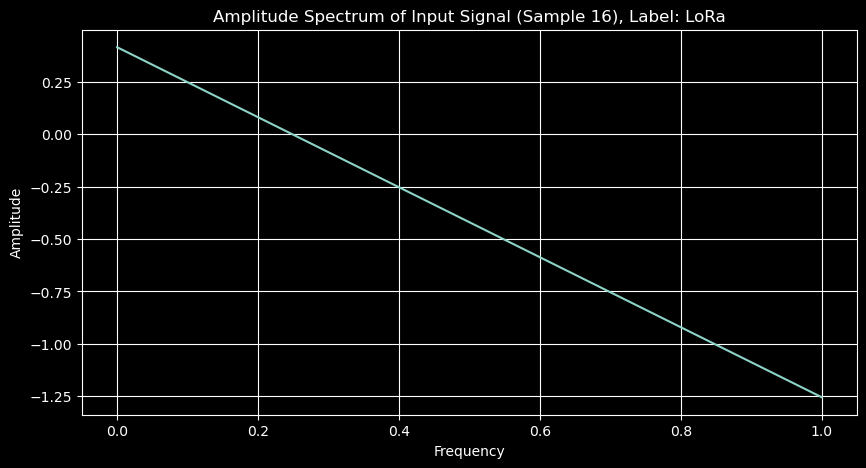

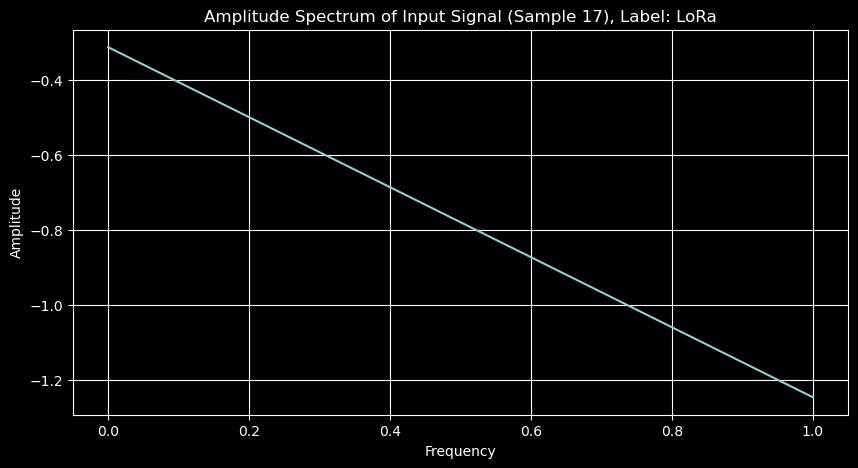

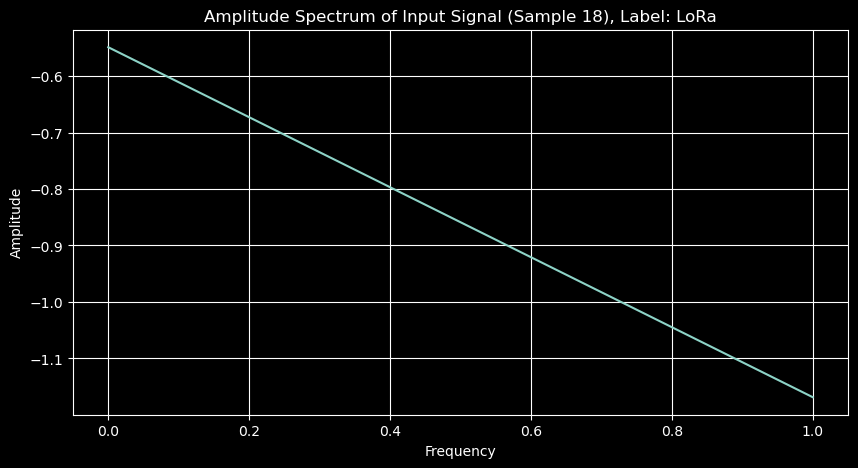

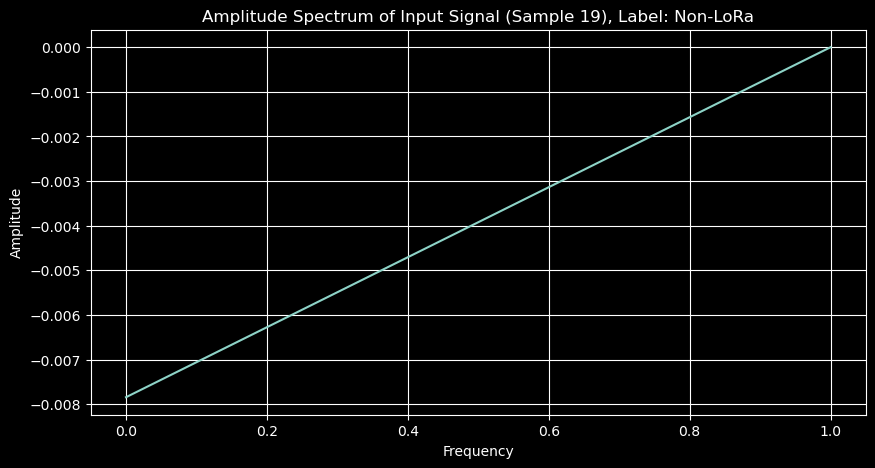

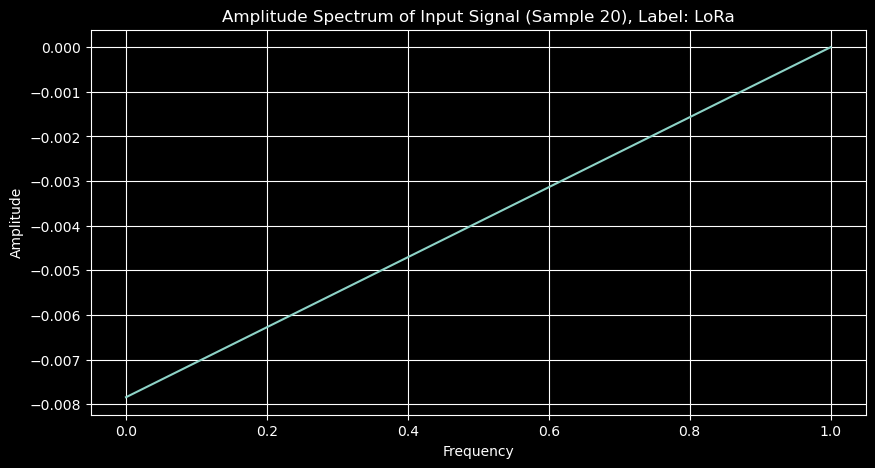

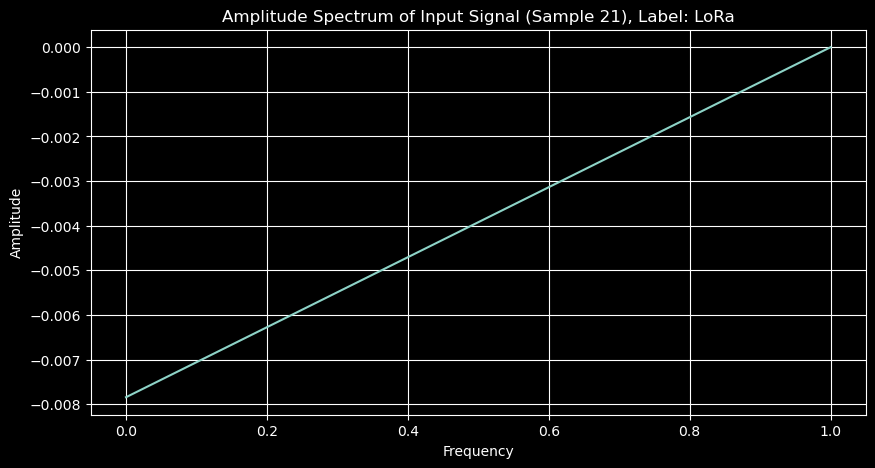

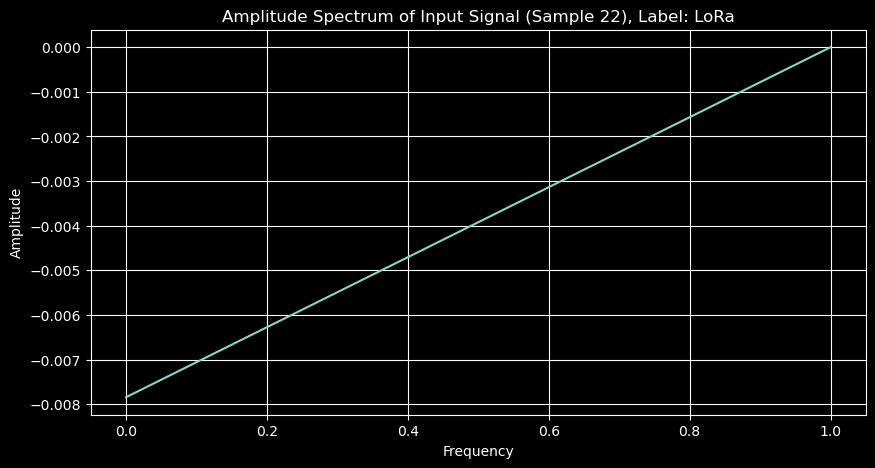

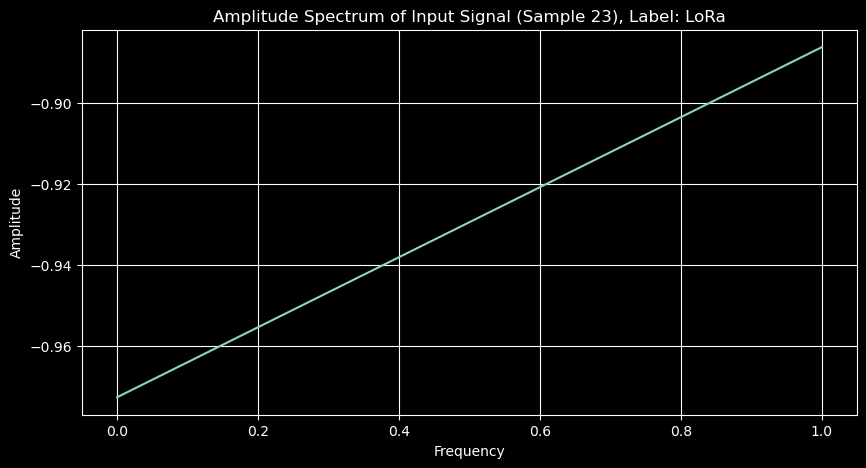

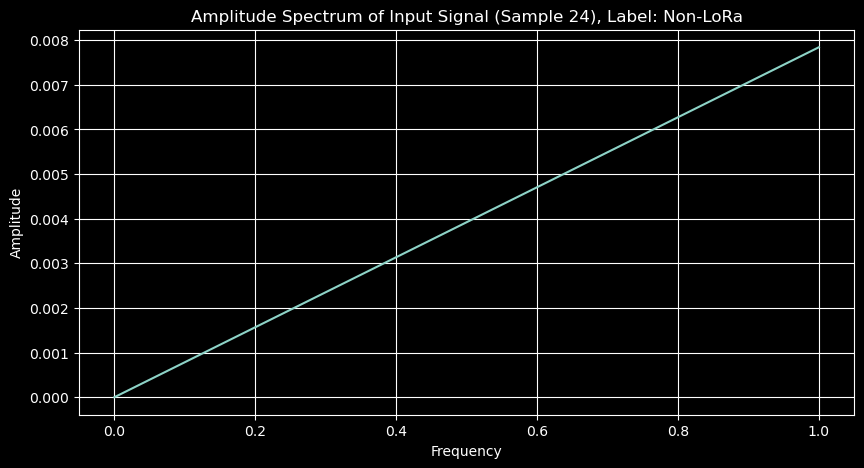

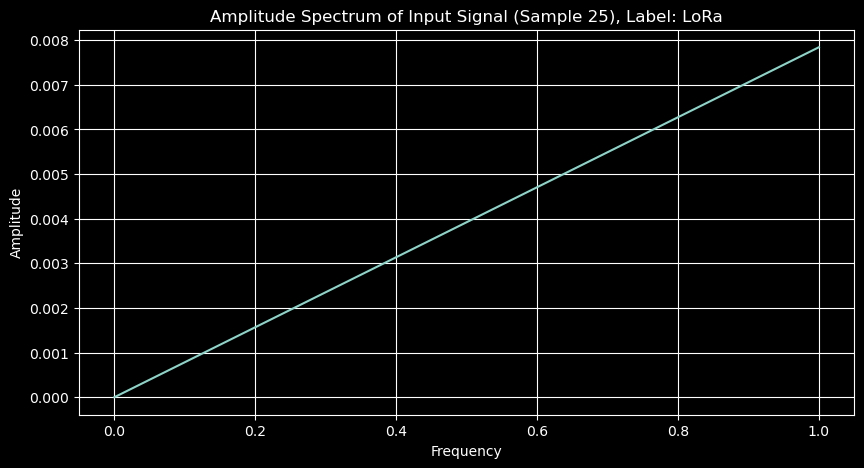

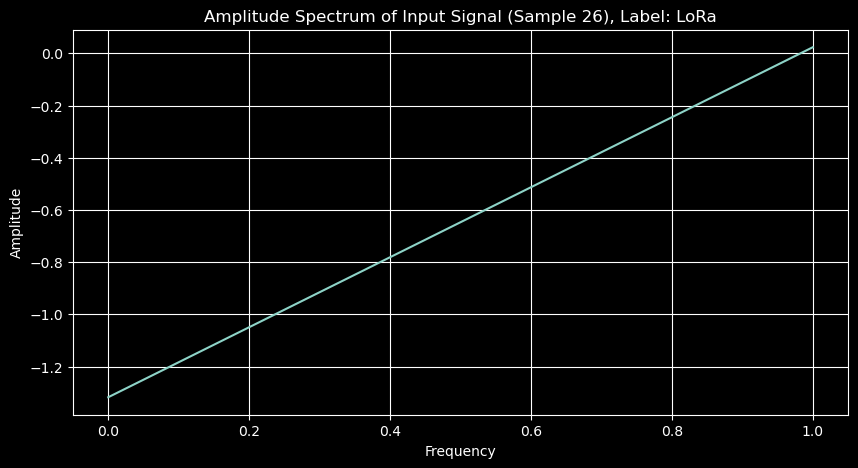

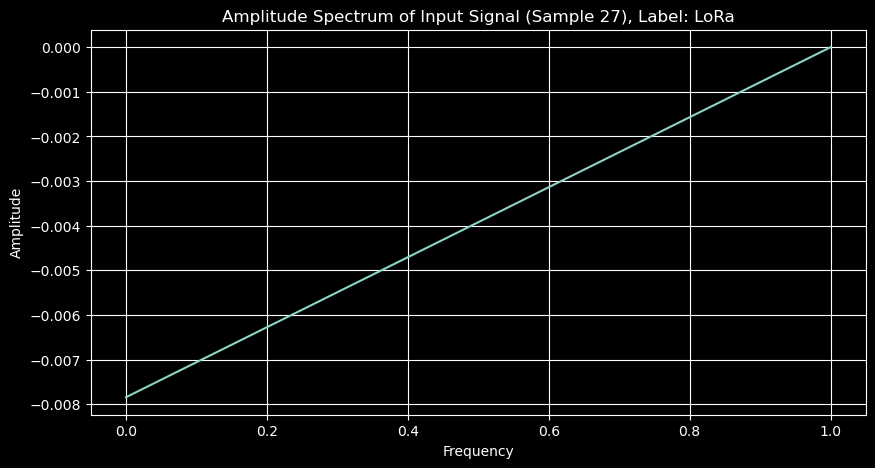

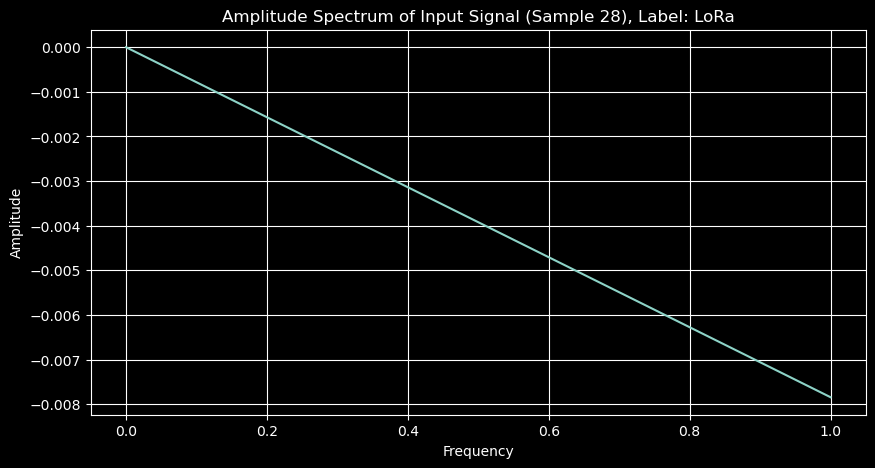

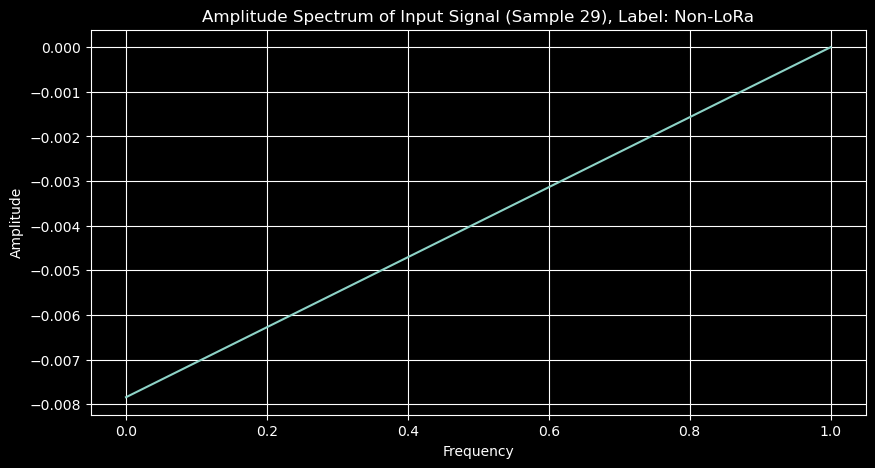

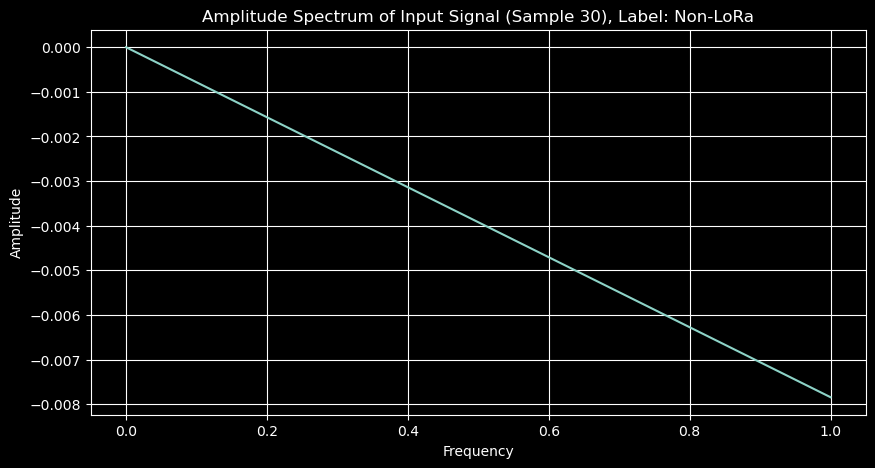

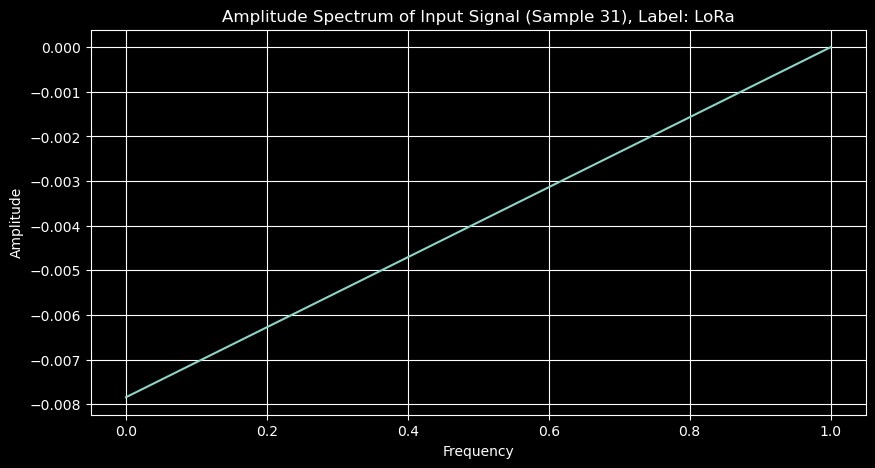

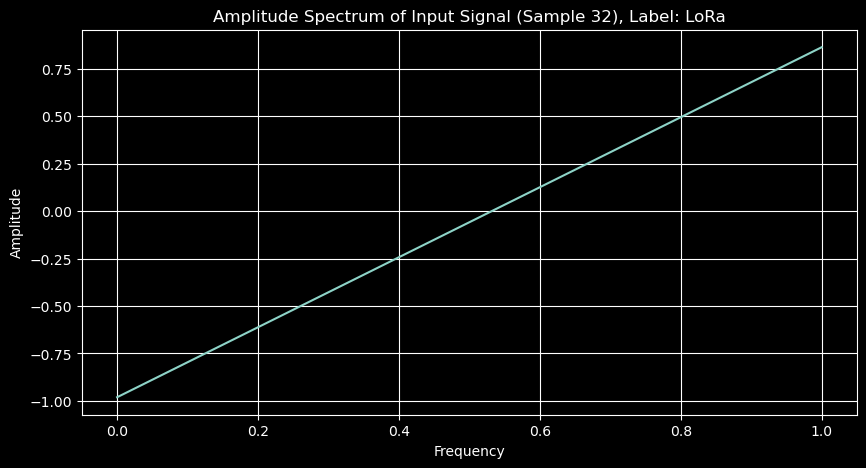

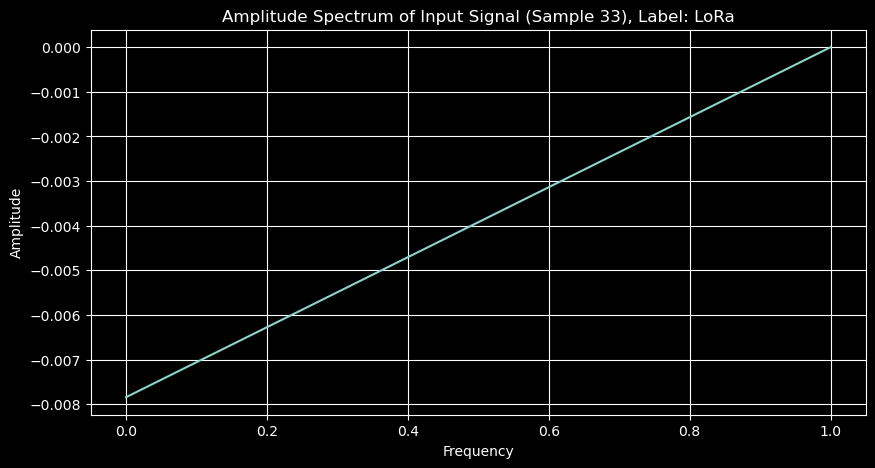

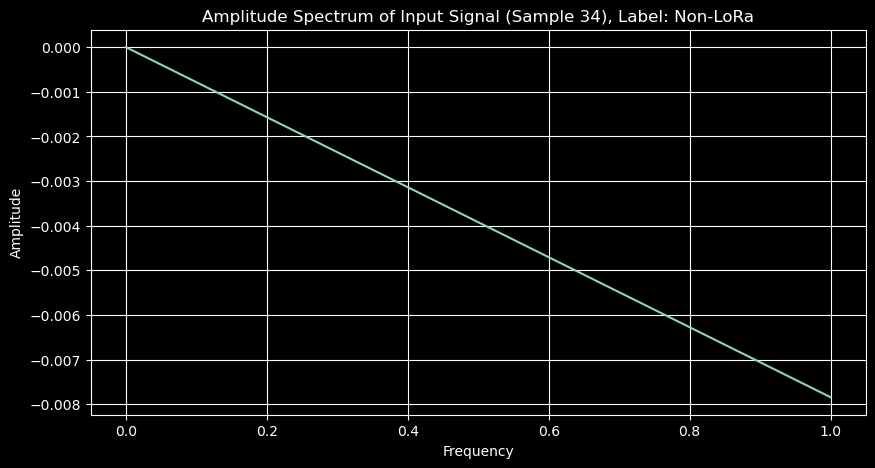

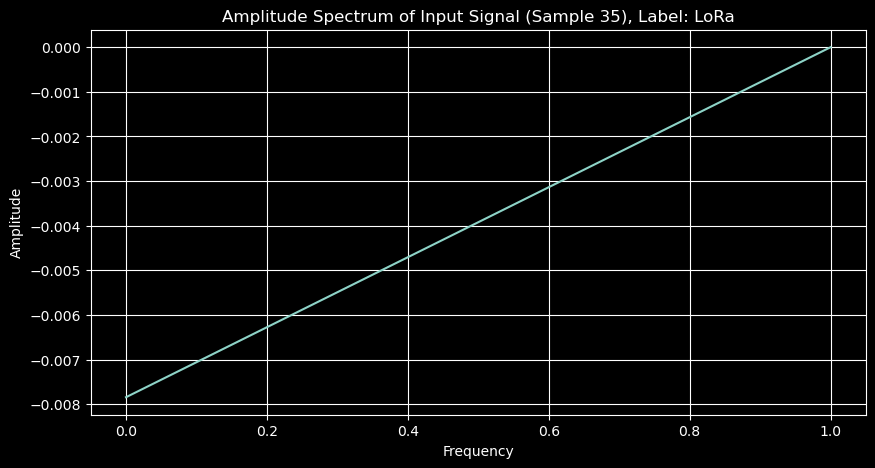

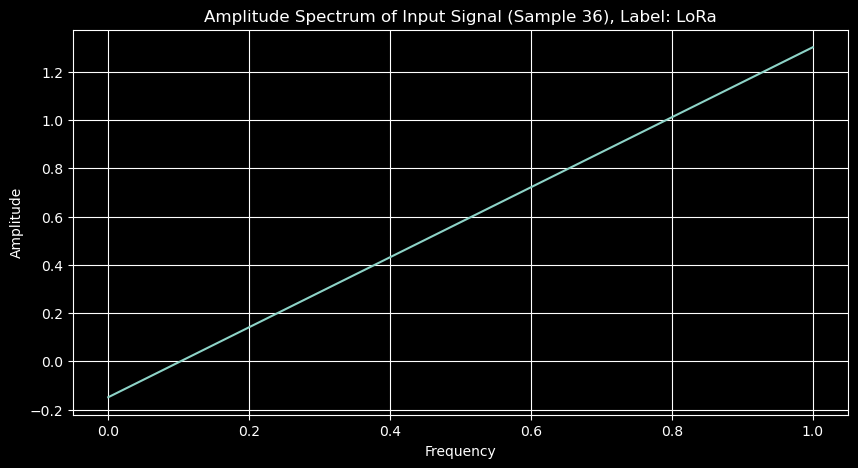

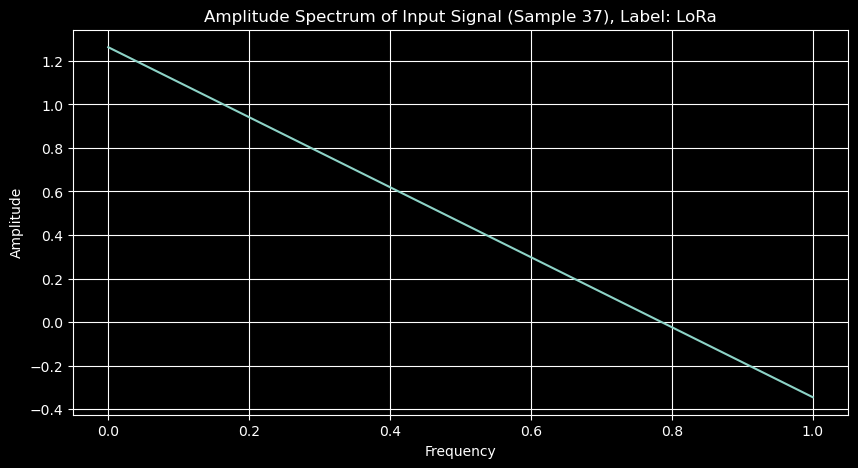

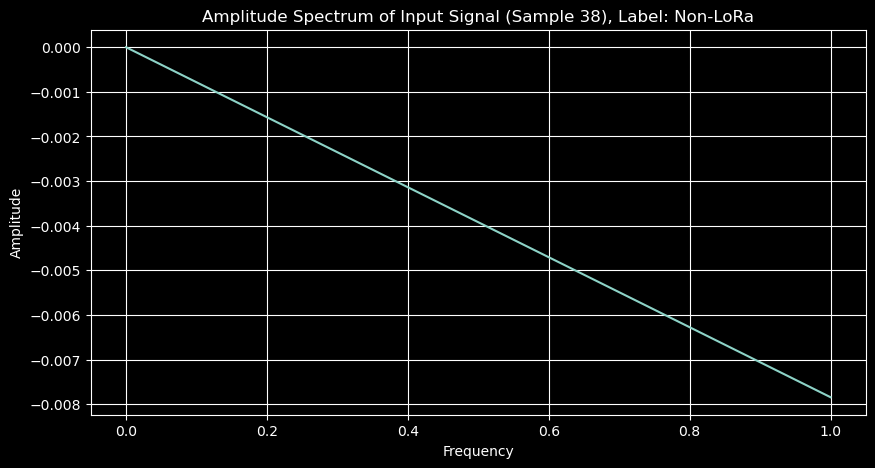

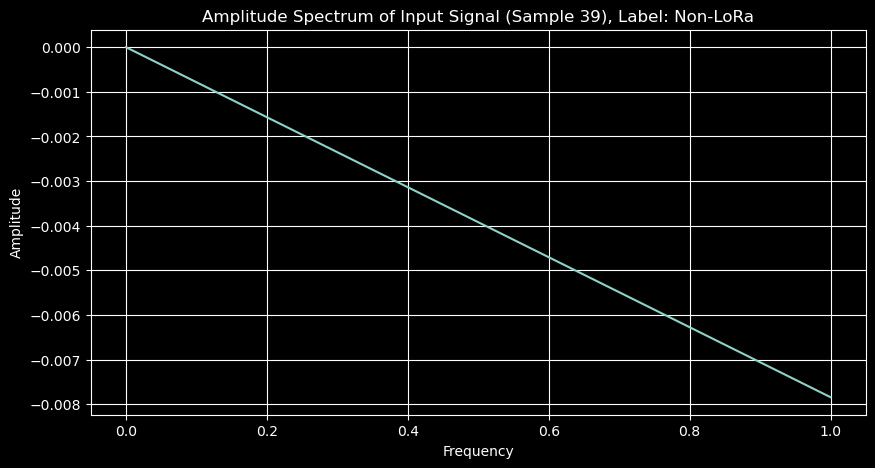

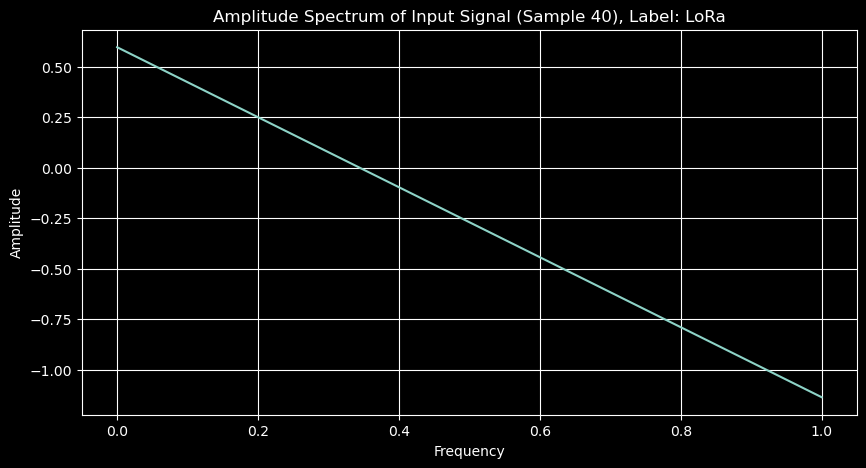

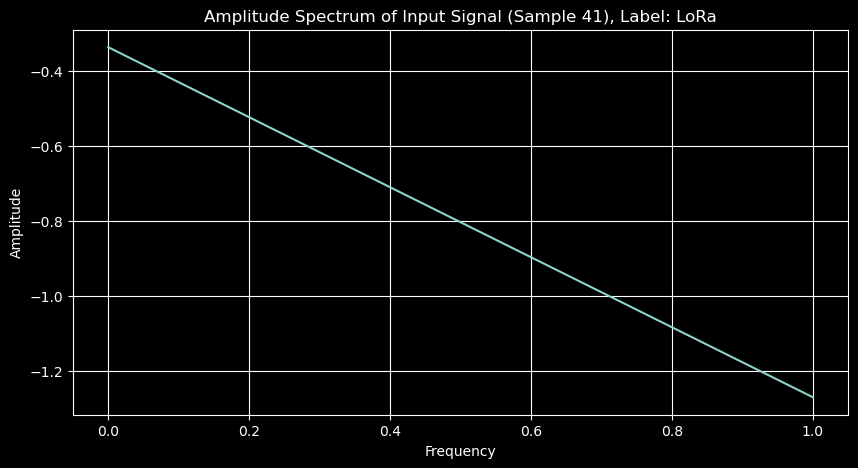

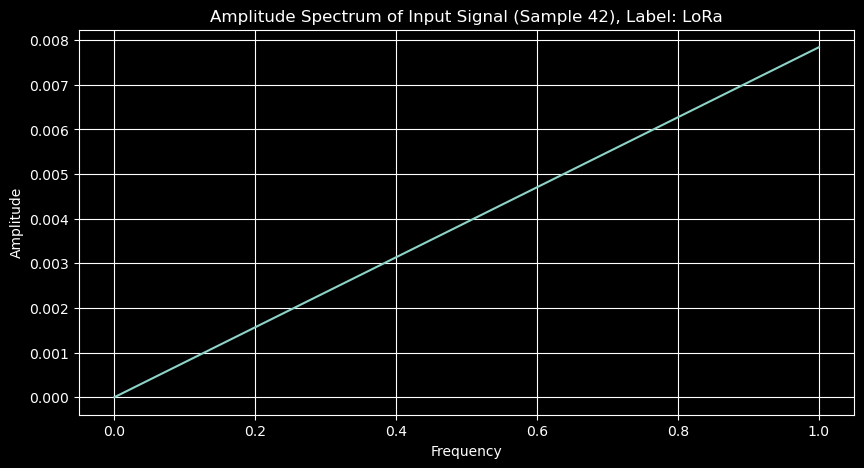

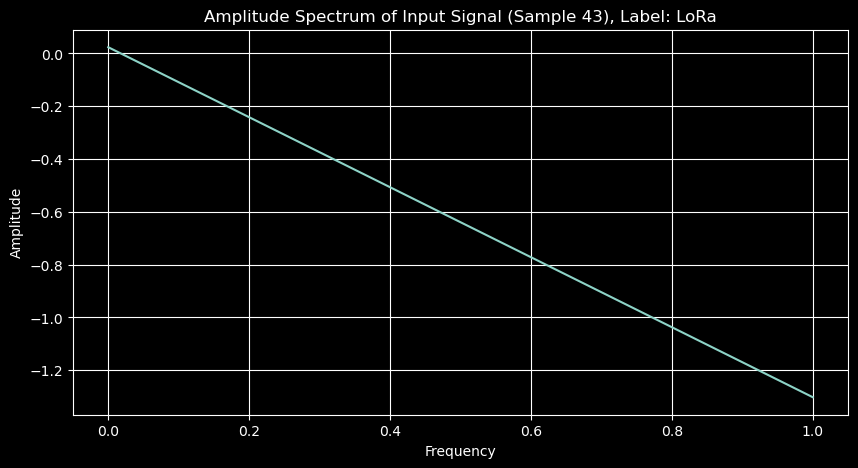

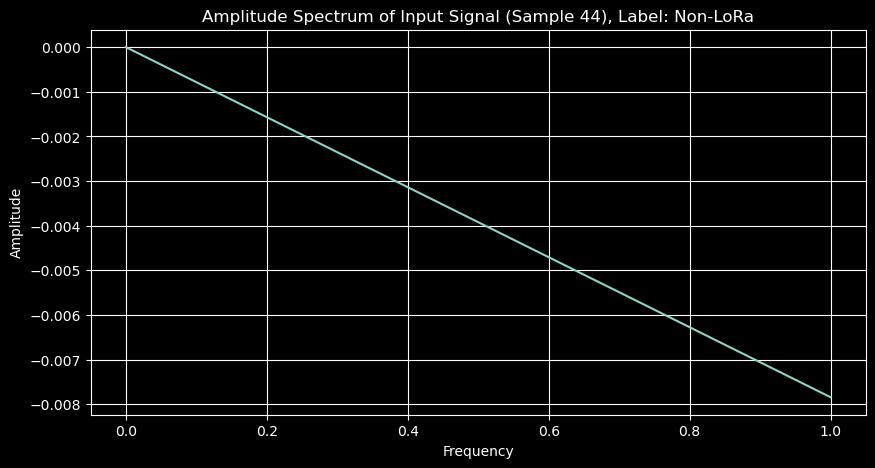

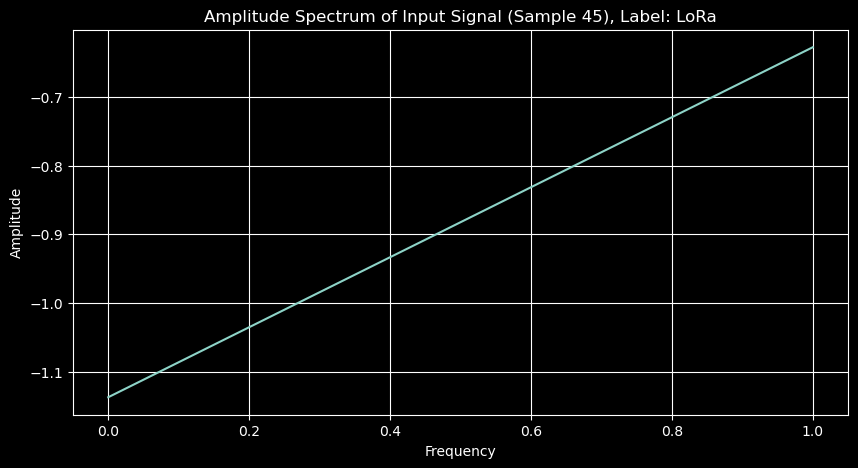

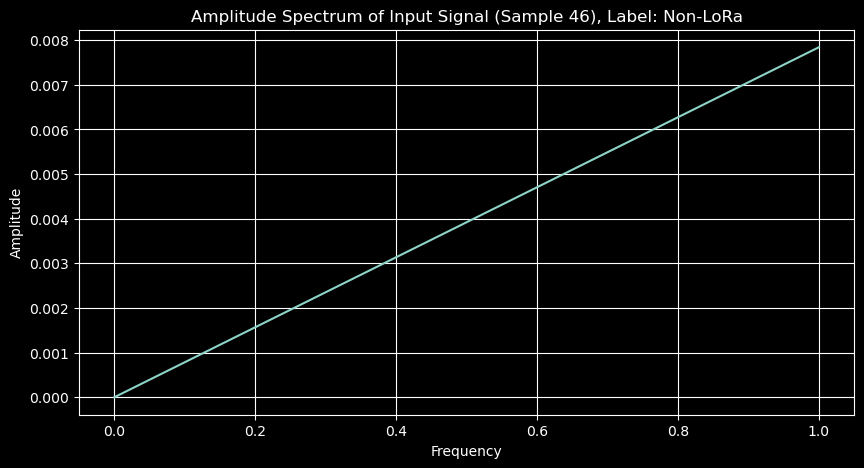

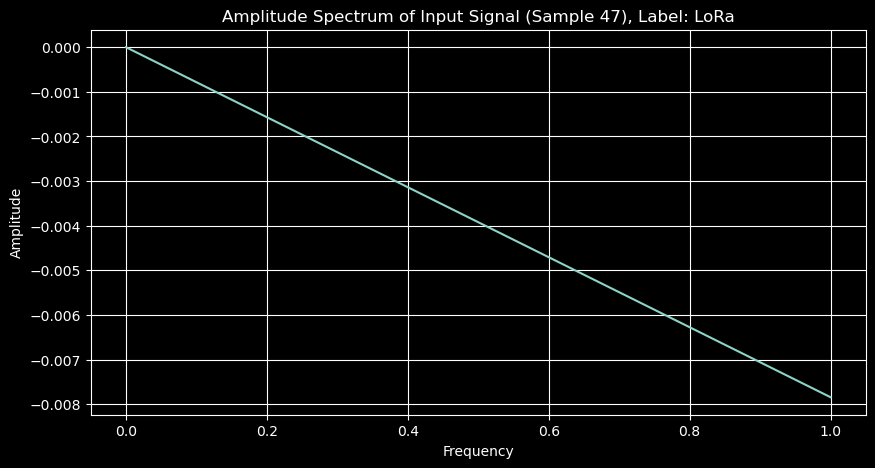

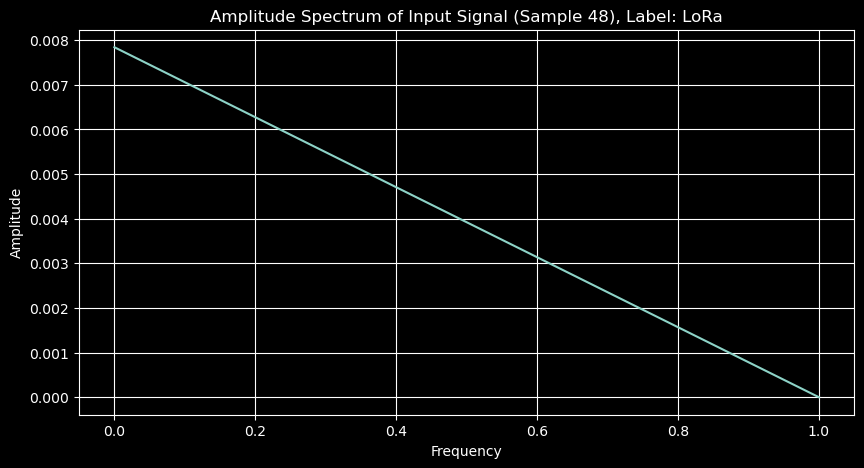

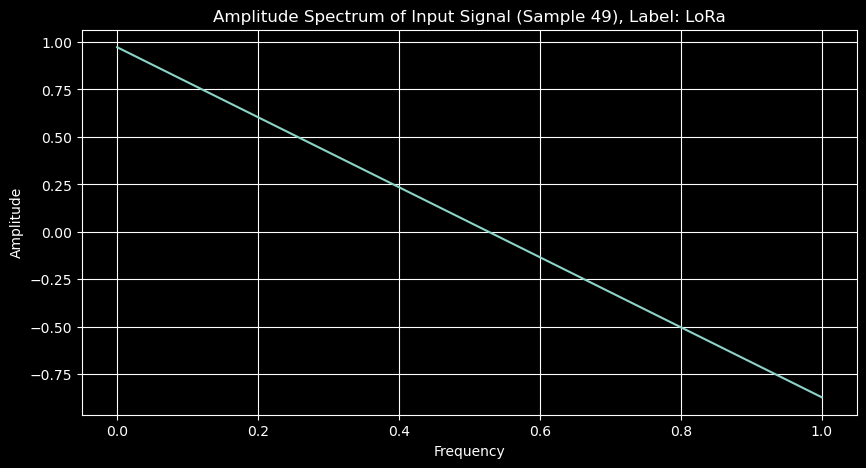

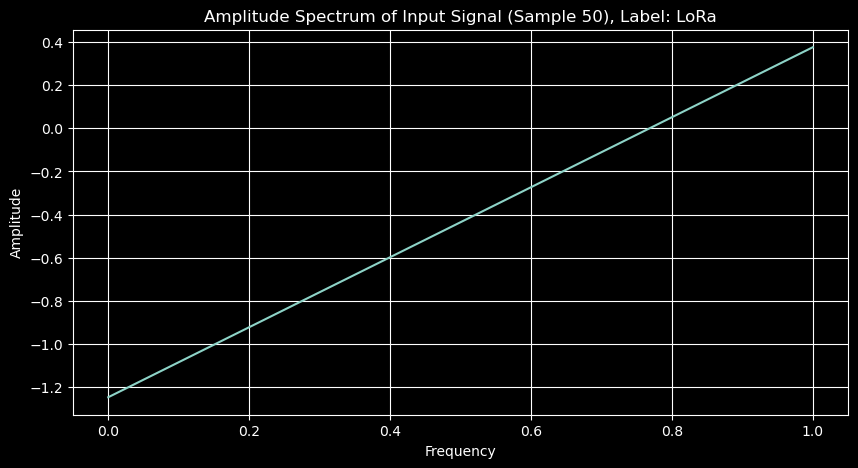

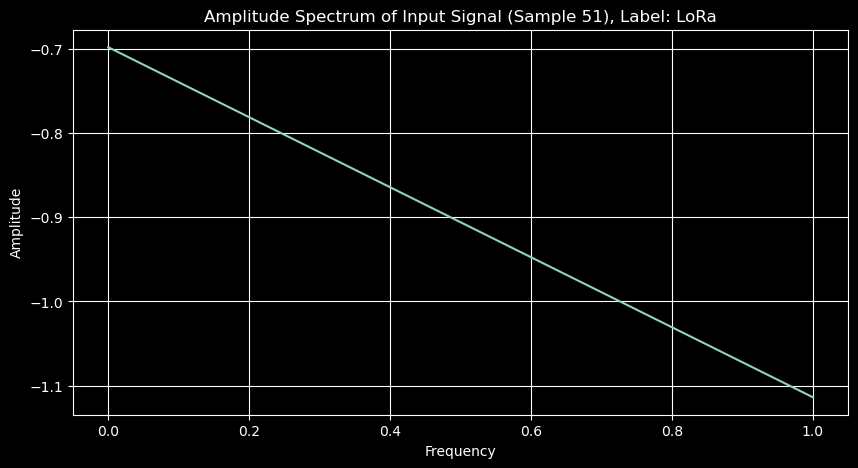

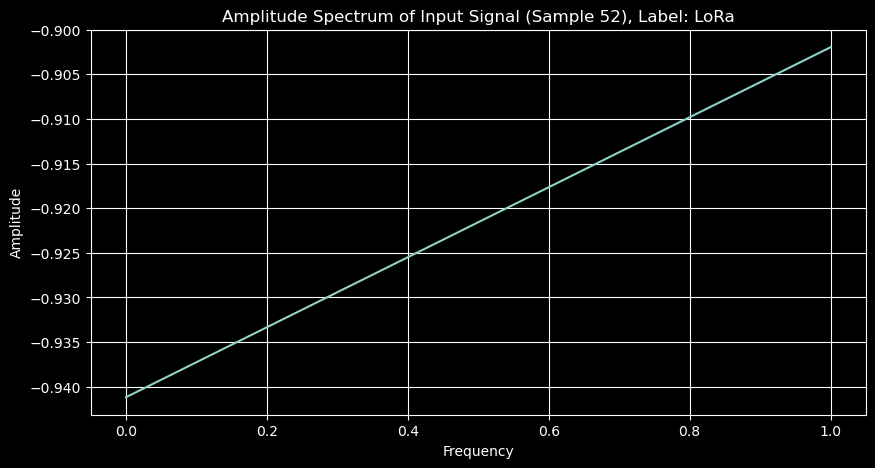

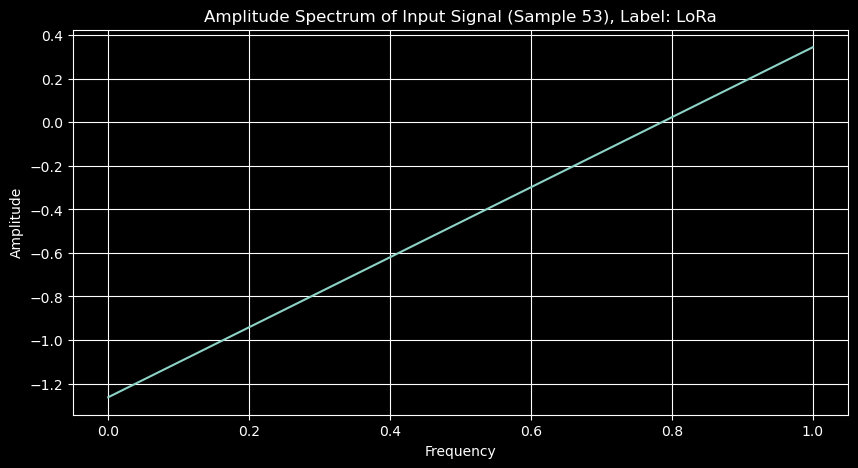

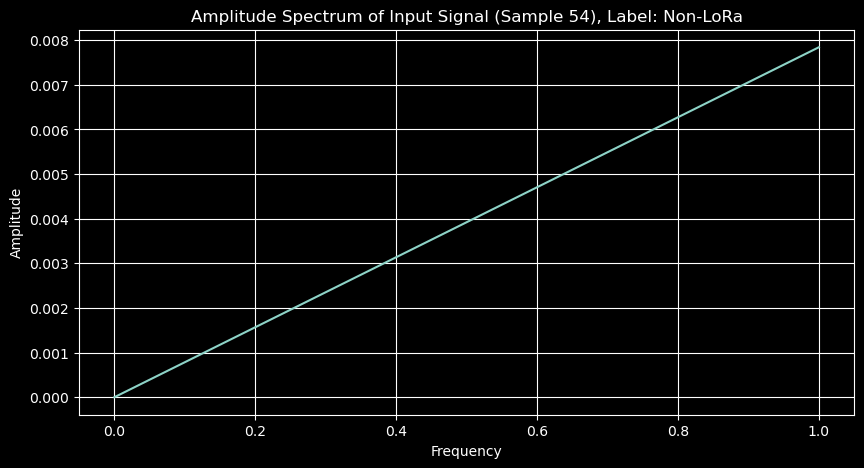

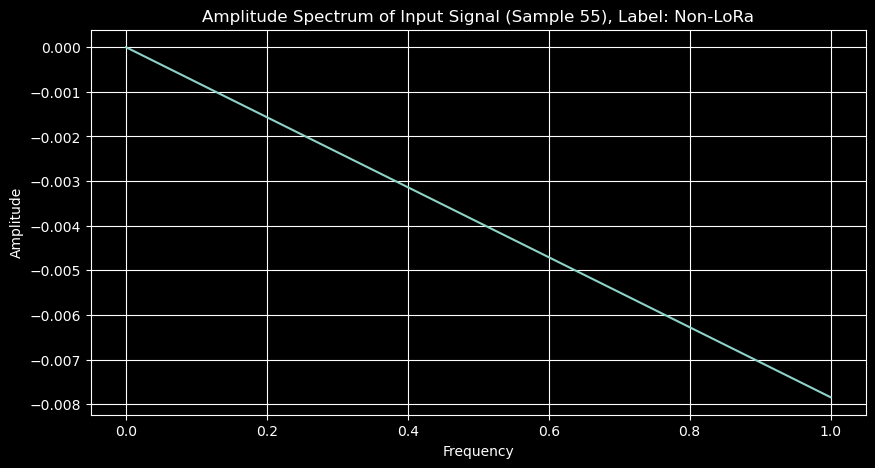

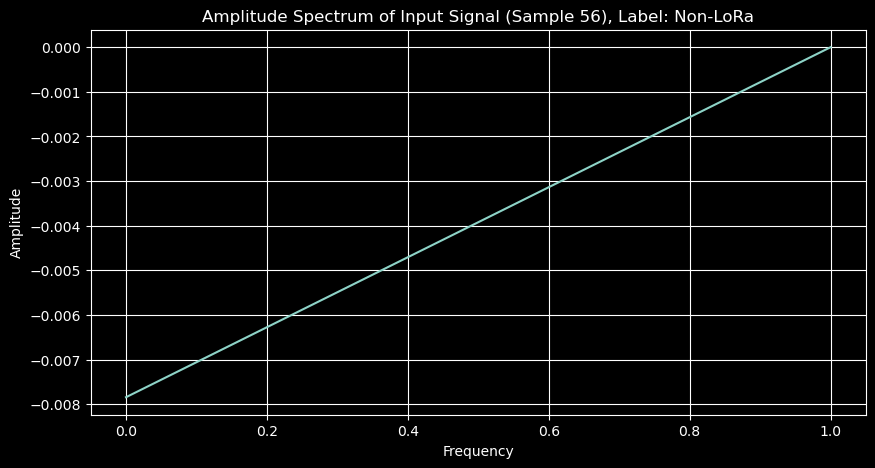

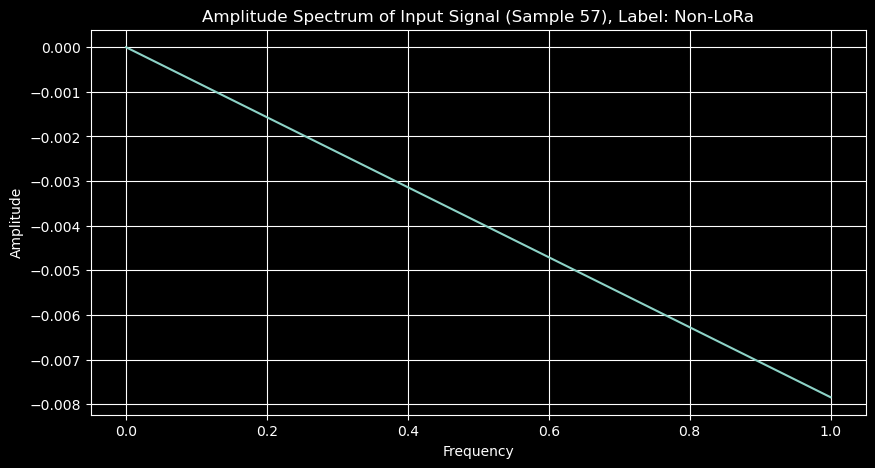

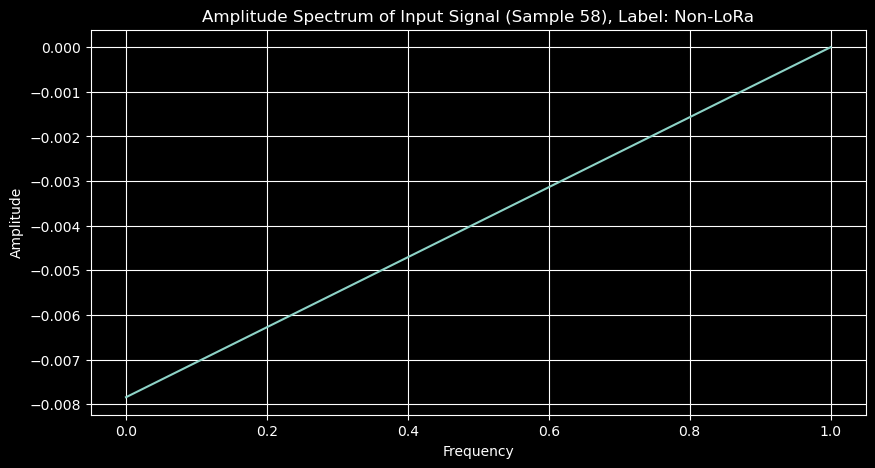

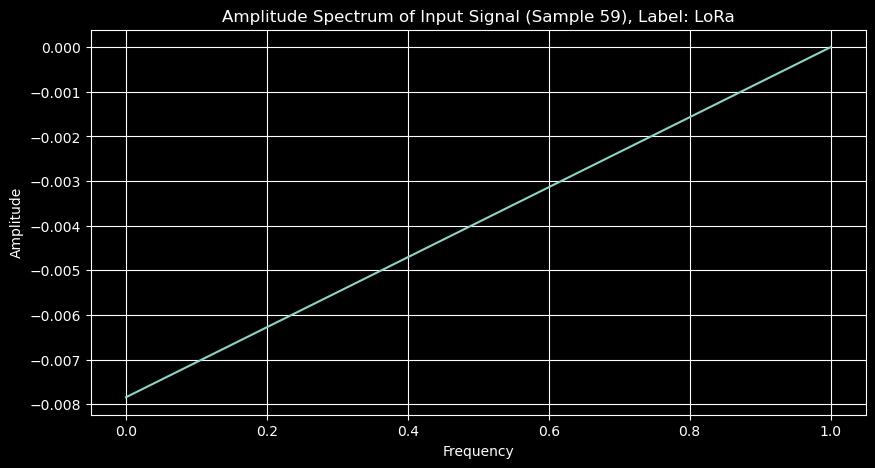

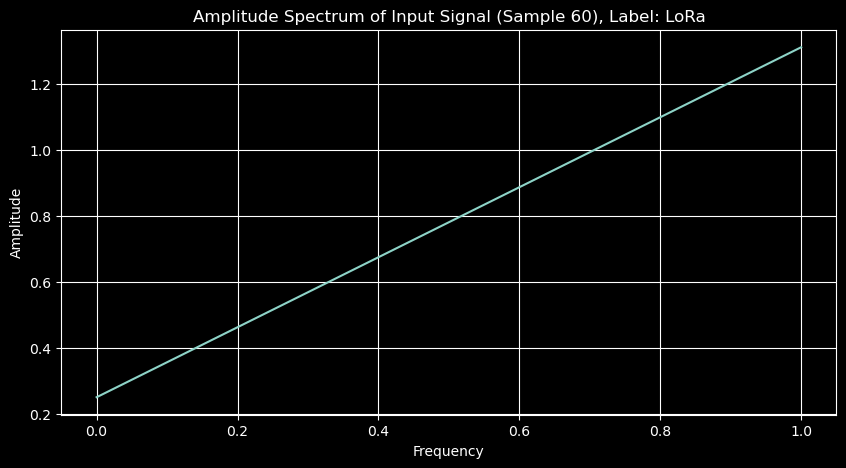

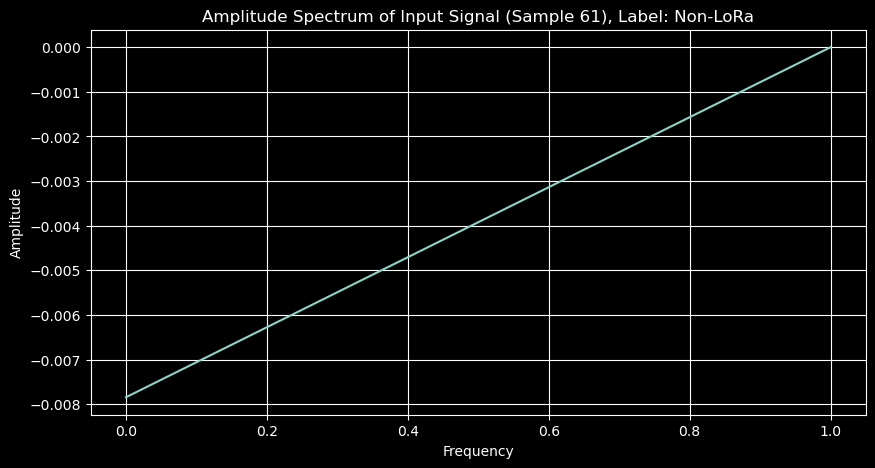

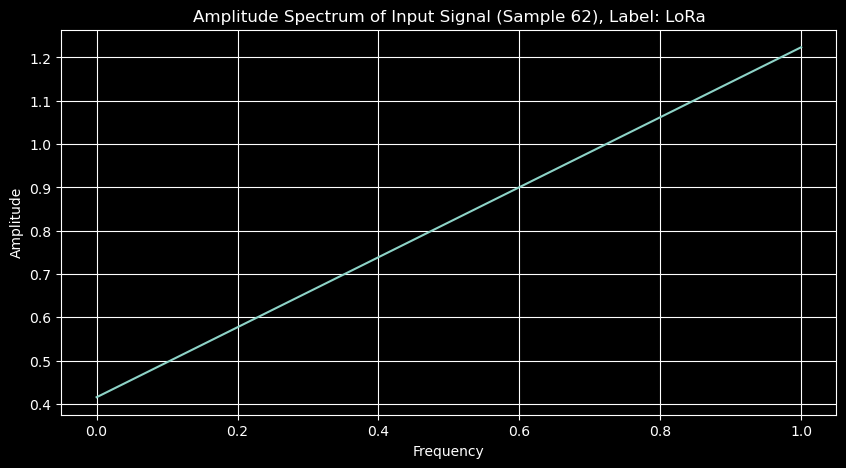

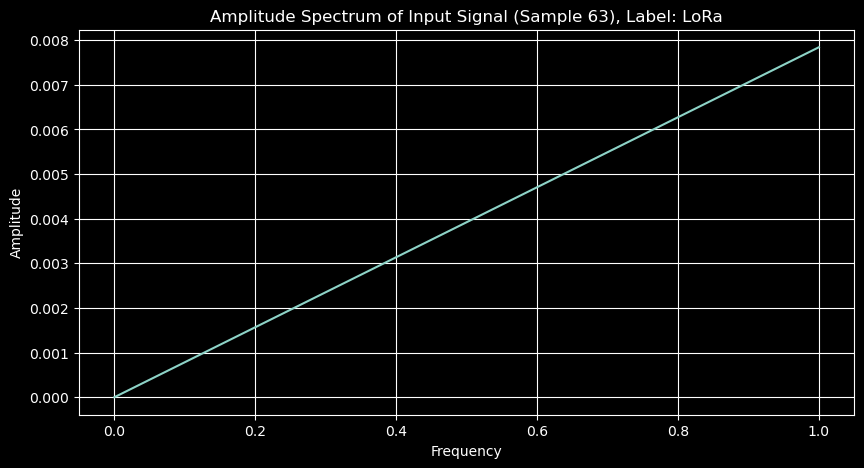

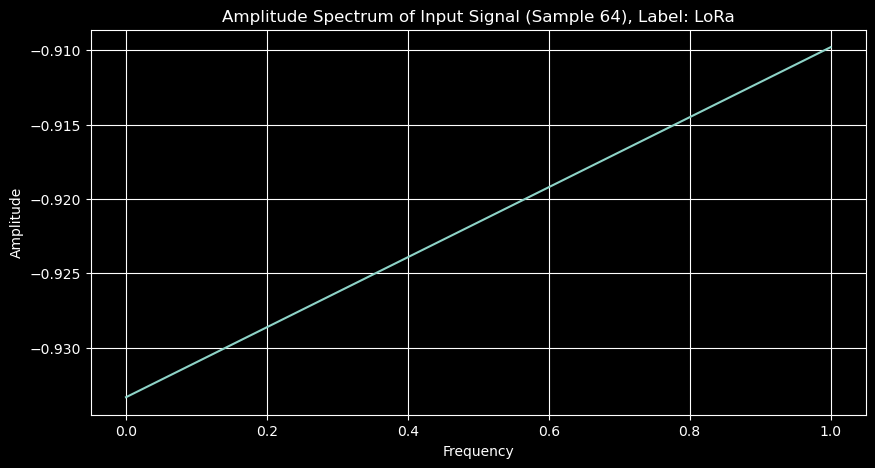

In [72]:
# Create a dictionary to map labels to integers
label_to_int = {'LoRa': 0, 'Non-LoRa': 1}  # You can adjust this mapping as needed

# Get a batch of input data
inputs, labels = next(iter(dataloaderT))  # Get a batch of data

# Convert the input tensor to a NumPy array and plot for each sample
num_samples = inputs.size(0)
for i in range(num_samples):
    # Convert the input tensor to a NumPy array
    input_array = inputs[i].detach().numpy()  # Get the input tensor for the i-th sample
    
    # Get the label for the i-th sample
    label_str = labels[i]  # Get the label string for the i-th sample
    label_int = label_to_int[label_str]  # Convert label string to integer
    
    # Plot the amplitude spectrum
    plt.figure(figsize=(10, 5))
    plt.plot(input_array[0])  # Assuming the input is a 1-channel signal
    plt.title(f'Amplitude Spectrum of Input Signal (Sample {i+1}), Label: {label_str}')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()
